In [1]:
#!rsync -avP cx1:~/HPC_data/pickled_data ~/HPC_data/

In [2]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
%run ./matplotlib_fig_settings.py

np.seterr(under = 'ignore')

#data_location = Path('/data/users/tch14/pickled_data')
#figure_location = Path('/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs')

data_location = Path('~/HPC_data/pickled_data').expanduser()
#figure_location = Path('~/DropBox/Apps/Overleaf/Short Paper/figs/').expanduser()
figure_location = Path('~/git/FK_short_paper/figs').expanduser()

width = columnwidth
height =  columnwidth / 2

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0
o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


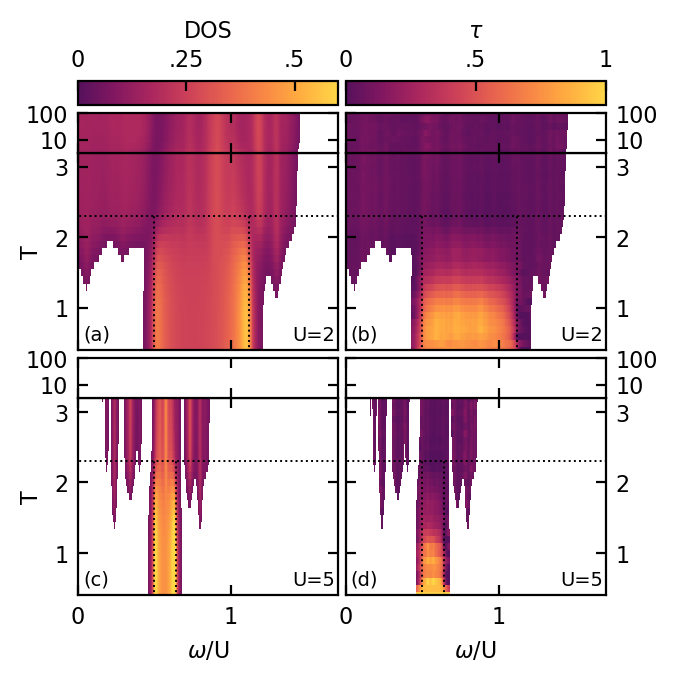

In [3]:
def plot_gap_opening_log_2x2(os, ologs = [None,None], xlim = (-3.5/2, 3.5/2)):
    from FKMC.general import smooth
    import matplotlib.gridspec as gridspec
    shading = 'nearest'
    
    f = plt.figure()
    #the overall grid has rows (cax, ax0, ax1) and two columns
    gs0 = gridspec.GridSpec(nrows = 3, ncols = 2, figure=f, wspace = 0.03,
                                            hspace = 0.05,
                                            height_ratios = (1,10,10),
                                            width_ratios = (1,1))
    caxes = [f.add_subplot(gs0[0,0]), f.add_subplot(gs0[0,1])]
    for j,o,olog in zip([1,2], os, ologs):
        #within each ax we split into axes and logaxes part with a subgridspec with hspace = 0
        lgs, rgs = [gs0[j, i].subgridspec(2,1, 
                                          height_ratios = (1,5),
                                          hspace = 0,
                                         ) for i in range(2)]
        axes = [f.add_subplot(lgs[1,0]), f.add_subplot(rgs[1,0])]
        logaxes = [f.add_subplot(lgs[0,0]), f.add_subplot(rgs[0,0])]


        print(f'o.Ns = {o.Ns}')
        i1 = 2; i2 = 0
        N1 = o.Ns[i1]; N2 = o.Ns[i2]
        print(f'N1 = {N1}, N2 = {N2}')


        E_i = 2
        E_threshold = 0.07
        E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
        E = np.where(E > 0.06, E, np.NaN)
        I = np.where(E > 0.06, -o.m, np.NaN)

        if olog:
            olog.E = smooth(olog.DOS[E_i], scale = 0.5, axis = -1)
            olog.E = np.where(olog.E > 0.06, olog.E, np.NaN)
            olog.I = np.where(olog.E > 0.06, -olog.m, np.NaN)
        
        custom_cmap.set_bad(color='white')
        
        #plot the E-T IPR diagram Diagram
        #the norm has to be fully specified (both vmin and vmax) so that the log and normal axes match
        DOSnorm = mpl.colors.Normalize(vmin = 0, vmax = 0.6)
        DOSpcol = axes[0].pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, E, norm = DOSnorm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)
        if olog: logaxes[0].pcolormesh(o.E_bins[1:]/o.parameters.U, olog.Ts, olog.E, norm = DOSnorm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)

        axes[0].set(ylabel = 'T', ylim = (0.1, 4), xlim = (-4, 4))

        #plot the E-T IPR diagram Diagram
        Taunorm = mpl.colors.Normalize(vmin = 0, vmax = 1)
        taupcol = axes[1].pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, I, norm = Taunorm, cmap= custom_cmap, linewidth=0, rasterized = True, shading = shading)
        if olog: logaxes[1].pcolormesh(o.E_bins[1:]/o.parameters.U, olog.Ts, olog.I, norm = Taunorm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)


        for a,b in zip(axes, logaxes): 
            #a.tick_params(direction = "in")
            b.tick_params(labelbottom = False)
            a.set(xlim = xlim)
            b.set(xlim = xlim)

            maxliny = 3.2

            a.set(ylim = (0.4,maxliny),
                  yticks = [0,1,2,3],
                  xlabel = '$\omega$/U',
            )
            b.set(yscale = 'log')
            b.set(
                ylim = (maxliny,100),
                yticks = [10,100],
                yticklabels = ['10','100'],
            )
            
        if j == 1: 
            for ax in axes: ax.tick_params(labelbottom = False)


        axes[1].tick_params(labelleft = False)

        for a in [axes[-1], logaxes[-1]]:
            a.tick_params(labelleft = False, labelright = True)
            
        labels = ["(a)","(b)"] if j == 1 else ["(c)","(d)"]
        for label, ax, color in zip(labels, axes, ['k', 'k']):
            ax.text(0.02, 0.03, label, transform=ax.transAxes, va='bottom', ha = 'left',
                    fontsize=7, fontweight='normal', color = color)
            ax.text(0.99, 0.03, f'U={o.parameters.U}', transform=ax.transAxes, va='bottom', ha = 'right',
                    fontsize=7, fontweight='normal', color = color)

        Tc = 2.3
        #pm 1/2 np.sqrt(4*U**2 + 8t**2(1 + cos(ka)))
        bounds = np.array([-1,-1,+1,+1]) * 0.5 * np.sqrt(o.parameters.U**2 + 8*np.array([0,2,0,2])) / o.parameters.U
        #bounds = [-2.3/2, -0.9/2, 0.9/2, 2.3/2]

        for ax in axes[:2]:
            ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'k')
            ax.vlines(x = bounds, ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'k')
        
        for a in axes: a.set(ylim = (0.4,maxliny))
    
    DOScbar = f.colorbar(DOSpcol, cax = caxes[0], orientation="horizontal")
    caxes[0].set(xlabel = 'DOS')  
    caxes[0].xaxis.set_label_position('top') 
    DOScbar.set_ticks([0, .25, .5])
    DOScbar.set_ticklabels(['0', '.25', '.5'])
    caxes[0].tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
    
    taucbar = f.colorbar(taupcol, cax = caxes[1], orientation="horizontal")
    caxes[1].set(xlabel = r'$\tau$')  
    caxes[1].xaxis.set_label_position('top') 
    taucbar.set_ticks([0, .5, 1])
    taucbar.set_ticklabels(['0', '.5', '1'])
    caxes[1].tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)

            
    f.subplots_adjust()
    f.set_size_inches(columnwidth,columnwidth)
    return f
 
with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
with open(Path('~/HPC_data/pickled_data/gap_opening_high_temp_log.pickle').expanduser(), 'rb') as file:
    olog = pickle.load(file)
    
with open(Path('~/HPC_data/pickled_data/gap_opening_U=5.pickle').expanduser(), 'rb') as file:
    oU5 = pickle.load(file)

f = plot_gap_opening_log_2x2(os = [o,oU5], ologs = [olog, None], xlim = (0,1.7))
f.savefig(figure_location / 'gap_openingboth.eps', bbox_inches='tight')

In [4]:
def log_params(data):
    print(f'Keys: {", ".join(data.keys())}')
    p = data.parameters
    m = data.MCMC_params
    print('Simulation Parameters')
    print(', '.join(f'{k} : {v}' for k,v in p.items() if k != 'J_matrix'))
    print('MCMC Parameters')
    print(', '.join(f'{k} : {v}' for k,v in m.items()))
    print()

<Figure size 680.8x680.8 with 0 Axes>

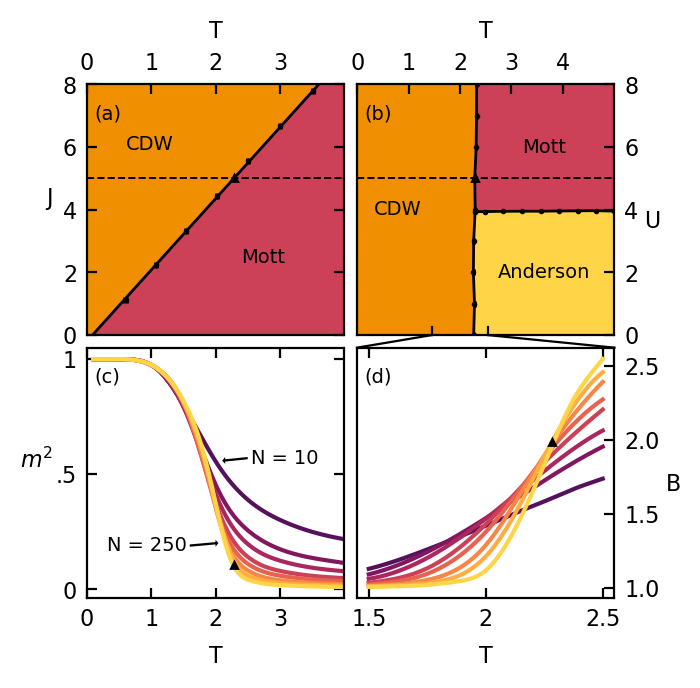

In [5]:
%run ./matplotlib_fig_settings.py
data_location = Path('~/HPC_data/pickled_data').expanduser()
from matplotlib.colors import to_rgba

cdw_color = to_rgba('#f09000')
gapped_color = to_rgba('#00afdb')
gapless_color = to_rgba('#e1a3f0')

#Sohpie's colour scheme
gapped_color = colors[3]
gapless_color = colors[-1]

#gapless_color = '#75c9f0' #light blue
#gapless_color = '#ea623b' #half way between cdw orange and colors[3]

cdw_gapped_midpoint = np.mean([cdw_color, gapped_color], axis = 0)

Tc = 2.25

from scipy.interpolate import interp1d, UnivariateSpline

def binder(ax):
    with open(data_location / 'binder_data.pickle', 'rb') as file: 
        d = oBinder = Munch(pickle.load(file))
    
    for i, N, c in zip(count(), d.Ns, colors):
        d.dB[i] = np.maximum(d.dB[i], d.dB[i].mean() * 0.1)
        binder_interped = UnivariateSpline(d.BX, d.B[i], w = 1/d.dB[i], s = len(d.BX))
        x = np.linspace(d.BX[0], d.BX[-1], 200)
        ax.plot(x, binder_interped(x), color = c)
        
    ax.set_ylabel('B', rotation=0, labelpad=5)
    ax.set_xlabel('T', rotation=0, labelpad=5)
        
def orderparam(ax):
    with open(data_location / 'binder_data.pickle', 'rb') as file: 
        d = oBinder = Munch(pickle.load(file))
    
    for i, N, c in zip(count(), d.Ns, colors):
        d.dM2[i] = np.maximum(d.dM2[i], d.dM2[i].mean() * 0.1)
        M_interped = UnivariateSpline(d.MX, d.M2[i], w = 1/(d.dM2[i] + 0.01*max(d.dM2[i])), s = len(d.MX))
        #axes[0].plot(d.MX, d.M2[i], linewidth = 1, color = c)
        #axes[0].errorbar(d.MX, d.M2[i], yerr = d.dM2[i] * 2, color = c, linestyle = "None", marker = '|', markersize = 0.5, label = f'N = {N}')

        x = np.linspace(d.MX[0], d.MX[-1], 200)
        ax.plot(x, M_interped(x), color = c)
        #spread(axes[0], d.MX, d.M2[i], d.dM2[i], alpha = 0.3, label = f'N = {N}', color = color)
        
        ax.set_ylabel('$m^2$', rotation=0, labelpad=7)
        ax.set_xlabel('T', rotation=0, labelpad=5)

def TJ_phase_diagram_T(ax):
    with open(data_location / 'TJ_phase_data.pickle', 'rb') as file: 
        TJ_data = pickle.load(file)   
        
    
    with open(data_location / 'TJ_phase_cdw_line.pickle', 'rb') as file: 
        crit_line = Munch(pickle.load(file))

    crit_fit_line = Munch(Ts = crit_line.fit.a*TJ_data.Js + crit_line.fit.b, Js = TJ_data.Js)
    
    ax.fill_betweenx(crit_fit_line.Js, x1 = 0, x2 = crit_fit_line.Ts, color = cdw_color)
    ax.fill_between(crit_fit_line.Ts, crit_fit_line.Js, color = gapped_color)
    ax.plot(crit_fit_line.Ts, crit_fit_line.Js,  color = 'black', marker = None, markersize = 0, linewidth = 1, linestyle = 'solid')
    
    ax.plot(crit_line.Ts, crit_line.Js,  color = 'black', marker = '.', markersize = 2, linewidth = 0)
    ax.errorbar(crit_line.Ts, crit_line.Js, xerr = crit_line.dTs, color = 'k', linewidth = 0.5, capsize = 1, linestyle = '')
        
    
    #pcol.set_edgecolor('face')
    ax.set(xlim = (0.1, 5), ylim = (0,10))
    ax.set_ylabel('J', rotation=0, labelpad=5)
    ax.set_xlabel('T', rotation=0, labelpad=5)
    
    ax.text(0.15, 0.8, "CDW", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')

    ax.text(0.6, 0.35, "Mott", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')

def TU_phase_diagram_T(ax):
    with open( data_location / 'TU_phase_data.pickle', 'rb') as file: 
        TU_data = pickle.load(file)   
        
    with open(data_location / 'TU_phase_gap_gapless_line.pickle', 'rb') as file: 
        gapped_gapless_line = Munch(pickle.load(file))
    
    with open(data_location / 'TU_phase_cdw_line.pickle', 'rb') as file: 
        cdw_line = Munch(pickle.load(file))
    
    
    from matplotlib.colors import LinearSegmentedColormap
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    colors = [(1,1,1,1), cdw_color]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)

    #### Critical Lines ################
    try:
        ix = gapped_gapless_line.T > p.Tc
        
        #tack on an extra point to the gap-gappless critical line to make it meet the cdw line
        gapped_gapless_line.U = np.concatenate([[gapped_gapless_line.U[ix][0]], gapped_gapless_line.U[ix]])[::2]
        gapped_gapless_line.T = np.concatenate([[p.Tc,], gapped_gapless_line.T[ix]])[::2]
        gapped_gapless_line.dU = np.concatenate([[gapped_gapless_line.dU[ix][0]], gapped_gapless_line.dU[ix]])[::2]
    
        ax.plot(gapped_gapless_line.T, gapped_gapless_line.U, color = 'black', marker = '.', markersize = 2, linewidth = 1)
        ax.errorbar(gapped_gapless_line.T, gapped_gapless_line.U, yerr = gapped_gapless_line.dU, color = 'k', linestyle = '')
        
        ax.plot(cdw_line.T, cdw_line.U,  color = 'black', marker = '.', markersize = 2, linewidth = 1)
        ax.errorbar(cdw_line.T, cdw_line.U, xerr = cdw_line.dT, color = 'k', linestyle = '', capsize = 1, linewidth = 1)
        
        #make a polygon for the gapped region starting from top right corner
        #               top right                   left edge                             bottom edge           bottom right
        T = np.concatenate([[5,], cdw_line.T[cdw_line.U > gapped_gapless_line.U[0]][::-1], gapped_gapless_line.T, [5,]])
        U = np.concatenate([[8,], cdw_line.U[cdw_line.U > gapped_gapless_line.U[0]][::-1], gapped_gapless_line.U, [4,]])
        xy = np.array([T,U]).T
        poly = mpl.patches.Polygon(xy, closed=True, fill=True, facecolor = gapped_color, edgecolor = None)
        ax.add_artist(poly)
        
        #make a polygon for the gappless region starting from top left
        #               
        T = np.concatenate([cdw_line.T[cdw_line.U < gapped_gapless_line.U[0]][::-1], [5,5], gapped_gapless_line.T[::-1]])
        U = np.concatenate([cdw_line.U[cdw_line.U < gapped_gapless_line.U[0]][::-1], [0,4], gapped_gapless_line.U[::-1]])
        xy = np.array([T,U]).T
        poly = mpl.patches.Polygon(xy, closed=True, fill=True, facecolor = gapless_color, edgecolor = None)
        ax.add_artist(poly)
        
        #make a polygon for the cdw region starting from top left
        #               
        T = np.concatenate([[0,0], cdw_line.T])
        U = np.concatenate([[8,0],cdw_line.U])
        xy = np.array([T,U]).T
        poly = mpl.patches.Polygon(xy, closed=True, fill=True, facecolor = cdw_color, edgecolor = None)
        ax.add_artist(poly)
        
        
    except AssertionError:
        pass
    ##### Text ##########################
    
    ax.set_ylabel('U', rotation=0, labelpad=5)
    ax.set_xlabel('T', rotation=0, labelpad=5)
    
    ax.set(ylim = (0,8), xlim = (0.1,5))
    
    ax.text(0.8, 4, "CDW", transform=ax.transData,
            fontsize=7, fontweight='normal', va='center', ha = 'center')

    ax.text((Tc+5)/2, 6, "Mott", transform=ax.transData,
            fontsize=7, fontweight='normal', va='center', ha = 'center')
    
    ax.text((Tc+5)/2, 2, "Anderson", transform=ax.transData,
        fontsize=7, fontweight='normal', va='center', ha = 'center')
    

f, axes = plt.subplots(2,2, gridspec_kw = dict(wspace = 0.05, hspace = 0.05))
axes = axes.flatten()
    
#the point at the binder crossing
p = Munch(J = 5, U = 5)

with open(data_location / 'TJ_phase_cdw_line.pickle', 'rb') as file: 
    crit_line = Munch(pickle.load(file))
p.Tc = crit_line.fit.a*5 + crit_line.fit.b

with open(data_location / 'binder_data.pickle', 'rb') as file: 
    d = oBinder = Munch(pickle.load(file))
p.B = np.interp(p.Tc, d.BX, d.B[-1]) 
p.m2 = np.interp(p.Tc, d.MX, d.M2[-1])
    
TJax = axes[0]
TUax = axes[1]
m2ax = axes[2]
binderax = axes[3]


##### The PT diagrams
TJ_phase_diagram_T(TJax)
TU_phase_diagram_T(TUax)
binder(binderax)
orderparam(m2ax)

## the triangular critical point marker
m = Munch(marker = '^', markersize = 2, color = 'black')
binderax.plot([p.Tc,], [p.B,], **m)
m2ax.plot([p.Tc,], [p.m2,], **m)
TJax.plot([p.Tc,], [p.J,], **m)
TUax.plot([p.Tc,], [p.U,], **m)

#### the M2 plot #####

#The m2 plot
m2ax.set(xlim = (0,4),
            xticks = [0,1,2,3],
            yticks = [0, 0.5, 1],
            yticklabels = ['0', '.5', '1']
            )

startx = 1.6; starty = 0.19;
endx = 2; endy = 0.2;
m2ax.arrow(startx, starty, endx-startx, endy-starty, width = 0.01, linewidth = 0.001, color = 'k')
m2ax.text(startx-0.05, starty, 'N = 250', fontsize = 7, ha = 'right', va = 'center')

startx = 2.5; starty = 0.57;
endx = 2.15; endy = 0.56;
m2ax.arrow(startx, starty, endx-startx, endy-starty, width = 0.01, linewidth = 0.001, color = 'k')
m2ax.text(startx+0.05, starty, 'N = 10', fontsize = 7, ha = 'left', va = 'center')


######## Things that depend on where the axis is rather than what is on it
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position("top")

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")

axes[1].xaxis.tick_top()
axes[1].xaxis.set_label_position("top")
    
axes[3].yaxis.tick_right()
axes[3].yaxis.set_label_position("right")

  
for letter, ax, c in zip('abcdef...', axes.flatten(), 'kkkk'):
    ax.text(0.03, 0.92, f"({letter})", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = c)



TJax.hlines(y = 5, xmin = 0, xmax = 5, linestyle = 'dashed', linewidth = 0.7, color = 'k')
TUax.hlines(y = 5, xmin = 0, xmax = 5, linestyle = 'dashed', linewidth = 0.7, color = 'k')

#the binder plot
binderax.set(xticks = [1.5, 2, 2.5],
            xticklabels = ['1.5', '2', '2.5'],
           )

#the TJ plot
TJax.set(xlim = (0,4),
            xticks = [0,1,2,3],
            yticks = [0, 2, 4, 6, 8],
            ylim = (0,8),
            )

TUax.set(xlim = (0,5),
            xticks = [0,1,2,3,4],
            yticks = [0, 2, 4, 6, 8],
            ylim = (0,8),
            )

#work in figure coords where (0,0) is bottom left and (1,1) top right
(_, _), (_, y0) = binderax.get_position().get_points()
(_, y1), (_, _) = TUax.get_position().get_points()
y2 = y1 + 0.012

dont_care = 0

def datacoords_to_fig(ax, point): 
    trans = ax.transData + f.transFigure.inverted()
    return trans.transform_point(point) #transform to figure coords

import matplotlib.lines as lines

lineargs = dict(
    linewidth=0.8, linestyle=None, color='k', transform = f.transFigure,
)

for xval in binderax.get_xlim():
    (x0, _) = datacoords_to_fig(binderax, (xval, dont_care))
    (x1, _) = datacoords_to_fig(TUax, (xval, dont_care))
    f.add_artist(lines.Line2D([x0, x1], [y0, y1], **lineargs,))
    f.add_artist(lines.Line2D([x1, x1], [y1, y2], **lineargs,))
    
f.set_size_inches(columnwidth, columnwidth)
f.savefig(figure_location / 'phase_diagram.eps', bbox_inches='tight')

In [6]:
#with open(data_location / f'local_runs_processed_smoothed_june2.pickle', 'rb') as f:
#    o_local_runs = Munch(pickle.load(f))


Anderson Phase

U = 2
\omega_0 = 0.057
\tau_0 = 0.06\pm0.01
\omega_1 = 0.810
\tau_1 = 0.02\pm0.01

CDW Phase

U = 2
\omega_0 = 0.057
\tau_0 = 0.05\pm0.03
\omega_1 = 0.810
\tau_1 = 0.30\pm0.03

Mott Phase

U = 5
\omega_0 = 0.240
\tau_0 = 0.04\pm0.02
\omega_1 = 0.571
\tau_1 = 0.00\pm0.01

CDW Phase

U = 5
\omega_0 = 0.240
\tau_0 = 0.06\pm0.04
\omega_1 = 0.571
\tau_1 = 0.15\pm0.05


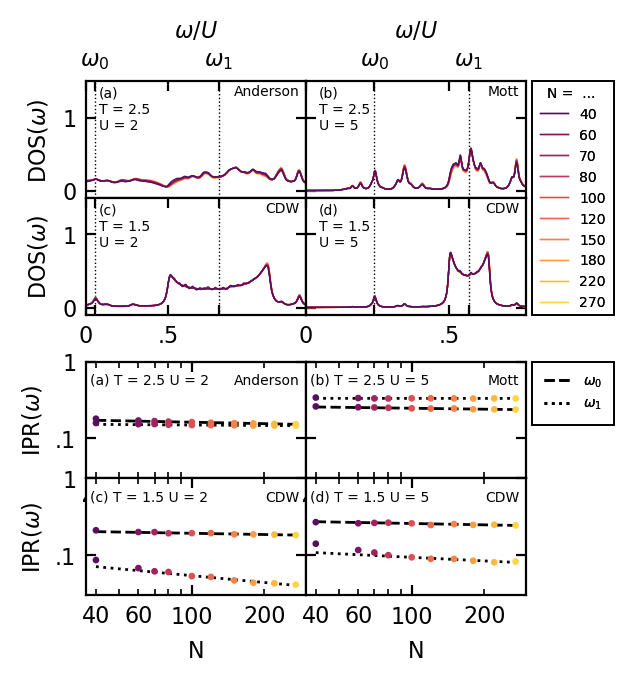

In [7]:
DOSxlim = np.array([0, 1.2])
DOSylim = (-0.1,1.5)

IPRylim = (0.03, 0.3)
Es = [
    lambda o: 1/16 * 0.9 if o.parameters.U == 2 else 1/4 * 0.96,
    lambda o: 1/4 * (1 + np.sqrt(1 + 16/o.parameters.U**2)),
     ]

linewidth = 0.5
legend_fontsize = 5
legend_wspace = 0.01
legend_labelspacing = 0.5
wspace = 0
hspace = 0

with open(Path('~/HPC_data/pickled_data/individual_IPRs.pickle').expanduser(), 'rb') as file:
    os = pickle.load(file)

from FKMC.general import get_nearby_index
from customcolors import colors, colors10

def pulloutbytemp_and_U(o, T_i, U_i):
    newo = o.copy()
    newo.DOS = newo.DOS[:, U_i, T_i]
    newo.IPR = newo.IPR[:, U_i, T_i]
    newo.dDOS = newo.dDOS[:, U_i, T_i]
    newo.dIPR = newo.dIPR[:, U_i, T_i]
    newo.parameters.beta = 1 / o.Ts[T_i]
    newo.parameters.U = o.Us[U_i]
    return newo


def plot_DOS(ax, o, letter):
    DOS = np.where(o.DOS > 0.001, o.DOS, np.NaN)
    lines = [None for _ in o.Ns]
    for i, N in list(enumerate(o.Ns))[::-1]:
        lines[i], = ax.plot(o.E_bins[1:] / o.parameters.U, DOS[i], label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
        
    xlim = 1/2 * np.sqrt(1 + 16/o.parameters.U**2) * DOSxlim
    ax.set(xlim = xlim, ylim = DOSylim)
    
    #do the arrows showing where the IPRs are taken
    for e in Es: 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        x, y = (true_E, max(o.DOS[:, E_i]))
        ax.vlines(x, ax.get_ylim()[0], ax.get_ylim()[1], colors='k', linestyles='dotted', linewidth = linewidth)

    label = "\n".join([
             f"({letter})",
             f"T = {1 / o.parameters.beta}",
             f"U = {o.parameters.U}",
             ])
    ax.text(0.06, 0.96, label, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', color = 'black')
    
    return lines

def plot_IPR_scaling(ax, o, letter):
    lines = [None for _ in Es]
    print(f'\nU = {o.parameters.U}')
    for i, e, linestyle in zip(count(), Es, ['dashed', 'dotted']): 
        true_E, E_i = get_nearby_index(o.E_bins[1:] / o.parameters.U, e(o))
        print(f'\omega_{i} = {true_E:.3f}')
        IvN = np.array([o.IPR[i, E_i] for i, _ in enumerate(o.Ns)])
        dIvN = np.array([o.dIPR[i, E_i] for i, _ in enumerate(o.Ns)])

        #model is IPR(N) = A * N ^ (-tau)
        def IPR(N, A, tau): return A * N ** (-tau)
        idx = o.Ns > 70
        (A, tau), pcov = scipy.optimize.curve_fit(IPR, o.Ns[idx], IvN[idx], p0=(0.5, 0.5), sigma=dIvN[idx], absolute_sigma=True)
        dA, dtau = np.sqrt(np.diag(pcov))
        
        lines[i], = ax.plot(o.Ns, IPR(o.Ns, A, tau), linestyle = linestyle, color = 'k', marker = None, linewidth = linewidth*2)
        #ax.errorbar(o.Ns, IvN, yerr = dIvN, fmt = 'none', ecolor = 'k',
        #            elinewidth = linewidth / 2, capsize = 1, capthick = linewidth / 2)
        ax.scatter(o.Ns, IvN, c = colors10, s = 2, zorder = 3)
        
        def errorfmt(a, da):
            digit = -int(np.floor(np.log10(da)))
            d = f'{da:.1g}'[-1]
            return f'{a:.{digit}f}({d})'
        
        print(f'\\tau_{i} = {tau:.2f}\pm{dtau:.2f}')
        
        
        ax.set(
               yscale = 'log', 
               xscale = 'log',
               ylim = IPRylim,
              )
        
    label = " ".join([
             f"({letter})",
             f"T = {1 / o.parameters.beta}",
             f"U = {o.parameters.U}",
             ])
    ax.text(0.02, 0.9, label, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', color = 'black')
    return lines

f = plt.figure(constrained_layout=False)

#make a split between the top and bottom
gs = f.add_gridspec(ncols = 1, nrows = 2, hspace = 0.2)
groups = [None, None]
legend_axes = [None, None]

for i in range(2):
    sgs = gs[i].subgridspec(nrows = 2, ncols = 3, 
                                      width_ratios=[1, 1, 0.4],
                                      hspace = 0,
                                      wspace = 0,
                                     )
    groups[i] = np.array([
                 [f.add_subplot(sgs[0, 0]), f.add_subplot(sgs[1, 0])],
                 [f.add_subplot(sgs[0, 1]), f.add_subplot(sgs[1, 1])],
                ])
           
    legend_axes[i] = f.add_subplot(sgs[:, 2], visible = False)


for U_i, col, labels in zip(count(), groups[0], [['a','c'], ['b','d']]):
    for T_i, ax, label in zip([1,0], col, labels):
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        lines = plot_DOS(ax, o, label)
        
        ax.set(xticks = [0, 0.5] + [e(o) for e in Es],)
        
        if T_i == 1: #set the omega labels for the top of the DOS plot
            ax.tick_params(bottom = False, labelbottom = False, top = True, labeltop = True)
            ax.set(xticklabels = ['', ''] + [f'$\omega_{i}$' for i, _ in enumerate(Es)],
                  xlabel = '$\omega / U$',
                  )
            ax.xaxis.set_label_position('top')
            
        if T_i == 0: #set the numerical xlabels for the bottom of the DOS plot
            ax.tick_params(top = True, labeltop = False, labelbottom = True)
            ax.set(
            xticklabels = ['0', '.5'] + ['', '']
            )
            
        if U_i == 0: ax.set(ylabel = 'DOS($\omega$)')
            
        phase = 'CDW' if T_i == 0 else ('Anderson' if U_i == 0 else 'Mott')
        ax.text(0.97, 0.97, phase, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', ha='right', color = 'black')
        
        

for U_i, col, labels in zip(count(), groups[1], [['a','c'], ['b','d']]):
    for T_i, ax, label in zip([1,0], col, labels):
        phase = 'CDW' if T_i == 0 else ('Anderson' if U_i == 0 else 'Mott')
        print(f"\n{phase} Phase")
        o = pulloutbytemp_and_U(os, T_i = T_i, U_i = U_i)
        omega_lines = plot_IPR_scaling(ax, o, label)
        
        ax.set(yticks = [0.1, 1])
        
        if U_i == 0: ax.set(ylabel = 'IPR($\omega$)')
        if T_i == 0: ax.set(xlabel = 'N')
        if T_i == 1: 
            ax.tick_params(bottom = False, labelbottom = False)
            
        from matplotlib.ticker import StrMethodFormatter, NullFormatter, FixedFormatter, FixedLocator
        ax.yaxis.set_major_locator(FixedLocator([0.1, 1]))
        ax.yaxis.set_major_formatter(FixedFormatter(['.1', '1']) if U_i == 0 else NullFormatter())
        #ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}') if U_i == 0 else NullFormatter())
        ax.yaxis.set_minor_formatter(NullFormatter())
        
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
        #ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:.0f}'))
        
        import matplotlib.ticker as ticker
        ax.xaxis.set_minor_formatter(ticker.FuncFormatter(
            lambda x,pos: f"{x:.0f}" if x in [40.0, 60.0, 200.0] else ''
        ))

        ax.text(0.97, 0.90, phase, transform=ax.transAxes,
            fontsize=5, fontweight='normal', va='top', ha='right', color = 'black')

#turn off the yticks labels for the right column
for g in groups: 
    for a in g[1, :]:
        a.tick_params(axis = 'y', labelleft = False)
        
#turn off the x ticks labels for the upper rows:
for g in groups: 
    for a in g[:, 0]:
        a.tick_params(axis = 'x', labelbottom = False)

    

    
def add_side_legend(axes, legend_axis, lines, labels, loc = 'center', rect_redefine = None):
    from matplotlib.legend import Legend
    #get the x position of the right of the plots in figure coords
    _, (x0, _) = axes[1,0].get_position().get_points()
    #get the y position of the bottom of the plots in figure coords
    (_, y0), _ = axes[1,1].get_position().get_points()
    #get the top right of the legend axis
    _, (x1, y1) = legend_axis.get_position().get_points()
    
    if rect_redefine: x0, y0, x1, y1 = rect_redefine(x0, y0, x1, y1)

    rect = mpl.patches.Rectangle((x0+legend_wspace,y0),x1-x0-legend_wspace,y1-y0,
                                 linewidth=0.7,
                                 edgecolor='k',
                                 facecolor='none',
                                 transform = f.transFigure)
    f.add_artist(rect)
    
    leg = f.legend(
                 handles = lines, 
                 labels = labels,
                 frameon=True,
                 fontsize = legend_fontsize,
                 loc = loc,
                 bbox_to_anchor=rect.get_bbox(),
                labelspacing = legend_labelspacing,
               fancybox = False,
               bbox_transform=f.transFigure,
    )
    #modify the frame of the legend
    frame = leg.get_frame()
    frame.set(visible = False)
    
    f.add_artist(leg);
    return leg, rect
    
leg, rect = add_side_legend(axes = groups[0], legend_axis = legend_axes[0], lines=lines, 
                      labels = [f"{N}" for N in o.Ns])
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

leg, rect = add_side_legend(axes = groups[1], legend_axis = legend_axes[1], lines=omega_lines, loc = 'upper center', 
                    rect_redefine = lambda x0, y0, x1, y1: (x0, y1 - (y1-y0)*0.27, x1, y1),
                    labels = [f"$\omega_{i}$" for i,e in enumerate(Es)])

b = rect.get_bbox()
text = f"""(a) 
$\\tau_1$: 0.06(1)
$\\tau_2$: 0.06(1)
(b)
$\\tau_1$ = 0.06(1)
$\\tau_2$ = 0.06(1) 
(c)
$\\tau_1$ = 0.06(1)
$\\tau_2$ = 0.06(1)  
(d)
$\\tau_1$ = 0.06(1)
$\\tau_2$ = 0.06(1)
"""
#f.text(b.xmin + 0.01, rect.get_bbox().ymin, text, fontsize = 4, va = 'bottom', ha = 'left')

f.subplots_adjust()
f.set_size_inches(columnwidth, columnwidth)
f.savefig(figure_location / 'indiv_IPR.eps', bbox_inches='tight');

In [8]:
%%script bash
cd ~/git/FK_short_paper
./figs/convert_and_crop.sh
git add figs/*.eps
git add pdf_figs/*.pdf
git status
git commit -m 'automated figure push'
git pull
git push

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   figs/DOS_gap_opening_no_axes_no_white.eps
	modified:   figs/IPR_gap_opening_no_axes_no_white.eps
	modified:   figs/gap_openingboth.eps
	modified:   figs/indiv_IPR.eps
	modified:   figs/phase_diagram.eps

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	figs/DOS_gap_opening_no_axes.svg
	figs/DOS_gap_opening_no_axes_no_white.svg
	figs/Figure(1200x800)_gap_opening_no_axes.svg
	figs/IPR_gap_opening_no_axes.svg
	figs/IPR_gap_opening_no_axes_no_white.svg
	figs/gap_opening.svg
	figs/gap_opening_no_axes.svg

[master 06babb3] automated figure push
 5 files changed, 5 insertions(+), 5 deletions(-)
Already up to date.


bash: line 2: ./figs/convert_and_crop.sh: Permission denied
To github.com:TomHodson/FK_short_paper.git
   22d772d..06babb3  master -> master


o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


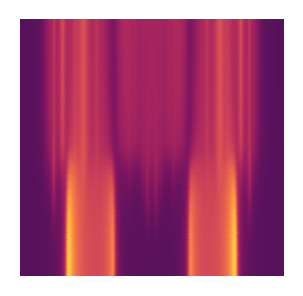

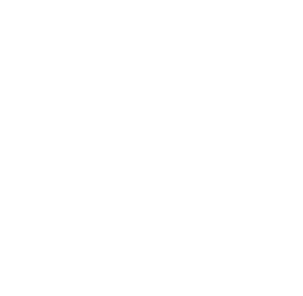

In [17]:
#make a simple one of just the heatmap
with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)

from FKMC.general import smooth

DOSf, DOSax = plt.subplots(ncols = 1, gridspec_kw = dict(wspace = 0.03,
                                                        hspace = 0.05))

IPRf, IPRax = plt.subplots(ncols = 1, gridspec_kw = dict(wspace = 0.03,
                                                        hspace = 0.05))

ax = DOSax
    
print(f'o.Ns = {o.Ns}')
i1 = 2; i2 = 0
N1 = o.Ns[i1]; N2 = o.Ns[i2]
print(f'N1 = {N1}, N2 = {N2}')

I1 = smooth(o.IPR[i1], scale = 0.5, axis = -1)
I2 = smooth(o.IPR[i2], scale = 0.5, axis = -1)

E_i = 2
E_threshold = 0.07
E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
#E = np.where(E > 0.07, E, np.NaN)


I = -o.m
#I = np.where(E > 0.07, I, np.NaN)


norm = mpl.colors.Normalize(vmin = 0)
custom_cmap.set_bad(color='white')
                       
pcol = ax.pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = 'gouraud')
ax.set(ylabel = 'T', xlabel = '$\omega$/U', ylim = (0.1, 4), xlim = (-4, 4))


#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
pcol = ax.pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, I, norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True, shading = 'gouraud')

for ax in [IPRax, DOSax]: 
    ax.set(ylim = (0.5,4))
    ax.axis('off')
    ax.set(xlim = (-3.5/2,3.5/2))
    
for f, name in zip([DOSf, IPRf], ["DOS", "IPR"]):
    f.subplots_adjust()
    f.set_size_inches(height, height)
    f.savefig(figure_location / f'{name}_gap_opening_no_axes_no_white.eps', bbox_inches='tight')
    f.savefig(figure_location / f'{name}_gap_opening_no_axes_no_white.svg', bbox_inches='tight')

In [10]:
"""
o = o_local_runs[1]
print(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

f = plt.figure(constrained_layout=False)
gs = f.add_gridspec(2, 2, width_ratios=[5, 1], wspace = 0, hspace = 0)
axes = [f.add_subplot(gs[0, :1]), f.add_subplot(gs[1, :1])]
legend_axis = f.add_subplot(gs[:, 1], visible = False)

axes[0].tick_params(axis = 'x', bottom = False, labelbottom = False)
axes[1].tick_params(axis = 'x', top = False, labeltop = False)

linewidth = 0.7

lines = [None for _ in o.Ns]
print(f"Ns = {o.Ns}")
for i,N in list(enumerate(o.Ns))[::-1]:
    lines[i], = axes[0].plot(o.E_bins[1:] / o.parameters.U, o.DOS[i], label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
    axes[1].plot(o.E_bins[1:] / o.parameters.U, o.IPR[i], color = colors10[i], linewidth = linewidth)

for a in axes: a.set(xlim = (0, 0.9))
    
axes[0].set(ylabel = 'DOS($\omega$)')
axes[1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$/U')

#axes[0].legend()

for a in axes: a.tick_params(direction = "in")
  
for label, ax in zip([f"(a) T = {1 / o.parameters.beta}","(b)","(c)"], axes):
    ax.text(0.01, 0.9, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
from matplotlib.legend import Legend
legend_fontsize = 5

#get the x position of the right of the plots in figure coords
_, (x0, _) = axes[0].get_position().get_points()
#get the y position of the bottom of the plots in figure coords
(_, y0), _ = axes[1].get_position().get_points()
#get the top right of the legend axis
_, (x1, y1) = legend_axis.get_position().get_points()

wspace = 0.01
rect = mpl.patches.Rectangle((x0+wspace,y0),x1-x0-wspace,y1-y0,
                             linewidth=0.7,
                             edgecolor='k',
                             facecolor='none',
                             transform = f.transFigure)
f.add_artist(rect)

leg = f.legend(
             handles = lines, 
             labels = [f"{N}" for N in o.Ns],
             frameon=True,
             fontsize = legend_fontsize,
             loc = 'center',
             bbox_to_anchor=rect.get_bbox(),
            labelspacing = 0.63,
           fancybox = False,
           bbox_transform=f.transFigure,
)
#modify the frame of the legend
frame = leg.get_frame()
frame.set(visible = False)

#change the title of the legend
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#add the legend to the figure
f.add_artist(leg);




f.subplots_adjust()
f.set_size_inches(width,height)
f.savefig(figure_location / 'mobility_edge_low_temp.eps', bbox_inches='tight');
"""

'\no = o_local_runs[1]\nprint(f\'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}\')\n\nf = plt.figure(constrained_layout=False)\ngs = f.add_gridspec(2, 2, width_ratios=[5, 1], wspace = 0, hspace = 0)\naxes = [f.add_subplot(gs[0, :1]), f.add_subplot(gs[1, :1])]\nlegend_axis = f.add_subplot(gs[:, 1], visible = False)\n\naxes[0].tick_params(axis = \'x\', bottom = False, labelbottom = False)\naxes[1].tick_params(axis = \'x\', top = False, labeltop = False)\n\nlinewidth = 0.7\n\nlines = [None for _ in o.Ns]\nprint(f"Ns = {o.Ns}")\nfor i,N in list(enumerate(o.Ns))[::-1]:\n    lines[i], = axes[0].plot(o.E_bins[1:] / o.parameters.U, o.DOS[i], label = f\'N = {N}\', color = colors10[i], linewidth = linewidth) \n    axes[1].plot(o.E_bins[1:] / o.parameters.U, o.IPR[i], color = colors10[i], linewidth = linewidth)\n\nfor a in axes: a.set(xlim = (0, 0.9))\n    \naxes[0].set(ylabel = \'DOS($\\omega$)\')\naxes[1].set(ylabel = \'IPR($\

In [11]:
"""
o = o_local_runs[2]
print(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')

f = plt.figure(constrained_layout=False)
gs = f.add_gridspec(2, 2, width_ratios=[5, 1], wspace = 0, hspace = 0)
axes = [f.add_subplot(gs[0, :1]), f.add_subplot(gs[1, :1])]
legend_axis = f.add_subplot(gs[:, 1], visible = False)

axes[0].tick_params(axis = 'x', bottom = False, labelbottom = False)
axes[1].tick_params(axis = 'x', top = False, labeltop = False)

linewidth = 0.7

lines = [None for _ in o.Ns]
print(f"Ns = {o.Ns}")
for i,N in list(enumerate(o.Ns))[::-1]:
    lines[i], = axes[0].plot(o.E_bins[1:] / o.parameters.U, o.DOS[i], label = f'N = {N}', color = colors10[i], linewidth = linewidth) 
    axes[1].plot(o.E_bins[1:] / o.parameters.U, o.IPR[i], color = colors10[i], linewidth = linewidth)

for a in axes: a.set(xlim = (0, 0.9))
    
axes[0].set(ylabel = 'DOS($\omega$)')
axes[1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$/U')

#axes[0].legend()

for a in axes: a.tick_params(direction = "in")
  
for label, ax in zip([f"(a) T = {1 / o.parameters.beta}","(b)","(c)"], axes):
    ax.text(0.01, 0.9, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
from matplotlib.legend import Legend
legend_fontsize = 5

#get the x position of the right of the plots in figure coords
_, (x0, _) = axes[0].get_position().get_points()
#get the y position of the bottom of the plots in figure coords
(_, y0), _ = axes[1].get_position().get_points()
#get the top right of the legend axis
_, (x1, y1) = legend_axis.get_position().get_points()

wspace = 0.01
rect = mpl.patches.Rectangle((x0+wspace,y0),x1-x0-wspace,y1-y0,
                             linewidth=0.7,
                             edgecolor='k',
                             facecolor='none',
                             transform = f.transFigure)
f.add_artist(rect)

leg = f.legend(
             handles = lines, 
             labels = [f"{N}" for N in o.Ns],
             frameon=True,
             fontsize = legend_fontsize,
             loc = 'center',
             bbox_to_anchor=rect.get_bbox(),
            labelspacing = 0.63,
           fancybox = False,
           bbox_transform=f.transFigure,
)
#modify the frame of the legend
frame = leg.get_frame()
frame.set(visible = False)

#change the title of the legend
leg.set_title("N =  ... ", prop = dict(size = legend_fontsize))

#add the legend to the figure
f.add_artist(leg);

f.subplots_adjust()
f.set_size_inches(width,height)
f.savefig(figure_location / 'mobility_edge_high_temp.eps', bbox_inches='tight');
"""

'\no = o_local_runs[2]\nprint(f\'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}\')\n\nf = plt.figure(constrained_layout=False)\ngs = f.add_gridspec(2, 2, width_ratios=[5, 1], wspace = 0, hspace = 0)\naxes = [f.add_subplot(gs[0, :1]), f.add_subplot(gs[1, :1])]\nlegend_axis = f.add_subplot(gs[:, 1], visible = False)\n\naxes[0].tick_params(axis = \'x\', bottom = False, labelbottom = False)\naxes[1].tick_params(axis = \'x\', top = False, labeltop = False)\n\nlinewidth = 0.7\n\nlines = [None for _ in o.Ns]\nprint(f"Ns = {o.Ns}")\nfor i,N in list(enumerate(o.Ns))[::-1]:\n    lines[i], = axes[0].plot(o.E_bins[1:] / o.parameters.U, o.DOS[i], label = f\'N = {N}\', color = colors10[i], linewidth = linewidth) \n    axes[1].plot(o.E_bins[1:] / o.parameters.U, o.IPR[i], color = colors10[i], linewidth = linewidth)\n\nfor a in axes: a.set(xlim = (0, 0.9))\n    \naxes[0].set(ylabel = \'DOS($\\omega$)\')\naxes[1].set(ylabel = \'IPR($\

In [12]:
#rsync -av cx1:~/HPC_data/pickled_data/ ~/HPC_data/pickled_data #needs the trailing slash

In [13]:
'''
from FKMC.general import smooth

width = columnwidth
height =  columnwidth
dpi = 150

f, axes = plt./matplotlib_fig_settings.pyll', sharex = 'all', gridspec_kw = dict(wspace = 0.1, hspace = 0.1))

with open( data_location / 'Long_range_IPR_and_DOS.pickle', 'rb') as file: LR_data = pickle.load(file)
with open(data_location / 'Short_range_IPR_and_DOS.pickle', 'rb') as file: SR_data = pickle.load(file)

#plot the E-T DOS Diagram

ax = axes[0,0]
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
I = smooth(LR_data.I, scale = 0.7, axis = -1)
E = smooth(LR_data.E_hist, scale = 0.7, axis = -1)

pcol = ax.pcolormesh(LR_data.E_bins, LR_data.Ts, E, cmap="RdBu_r", linewidth=0, rasterized = True)
ax.set(ylabel = 'DOS\nT', xlabel = '', ylim = (0.1,4), xlim = (-4, 4), title = 'Long Ranged')

    
#plot the E-T IPR diagram Diagram
ax = axes[1,0]
pcol = ax.pcolormesh(LR_data.E_bins, LR_data.Ts, I, cmap="RdBu_r", linewidth=0, rasterized = True)
ax.set(ylabel = 'IPR\nT', xlabel = '$\omega$', xlim = (-4, 4))

ax = axes[0,1]
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
I = smooth(SR_data.I, scale = 0.7, axis = -1)
E = smooth(SR_data.E_hist, scale = 0.7, axis = -1)

pcol = ax.pcolormesh(SR_data.E_bins, SR_data.Ts, E, cmap="RdBu_r", linewidth=0, rasterized = True)
ax.set(ylabel = '', xlabel = '', ylim = (0.1,4), xlim = (-4, 4), title = 'Short Ranged')

    
#plot the E-T IPR diagram Diagram
ax = axes[1,1]
pcol = ax.pcolormesh(SR_data.E_bins, SR_data.Ts, I, cmap="RdBu_r", linewidth=0, rasterized = True)
ax.set(xlabel = '$\omega$', xlim = (-4, 4))

for a in axes.flatten(): a.tick_params(direction = "in")
  
for label, ax in zip(["(a)","(b)","(c)","(d)"], axes.flatten()):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'white')

#f.subplots_adjust(bottom=0.2)
f.set_size_inches(width,height)
f.savefig(figure_location / 'band_opening_2.eps', bbox_inches='tight')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

width = columnwidth
height =  columnwidth / 2
dpi = 150
plot_binder = False


def TJ_phase_diagram(ax):
    with open(data_location / 'TJ_phase_data.pickle', 'rb') as file: 
        TJ_data = pickle.load(file)   
    
    print('TJ_data:')
    log_params(TJ_data)
    
    from matplotlib.colors import LinearSegmentedColormap
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    colors = [(1,1,1,1), (1,0.6,0,1)]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    #TJ_data.hints.Mf_moments == ('Ns', 'repeats', 'Js', 'Ts', 'moment', 'MCstep')
    M2 = TJ_data.Mf_moments[-1, :, :, :, 2].mean(axis = (0)).T
    M4 = TJ_data.Mf_moments[-1, :, :, :, 4].mean(axis = (0)).T
    Y = M2**2 / M4 if plot_binder else M2
    
    pcol = ax.pcolormesh(TJ_data.Js, TJ_data.Ts, Y, cmap=cmap, norm = norm, shading = 'gouraud', linewidth=0, rasterized = True)
    #pcol.set_edgecolor('face')
    ax.set(ylabel = 'T', xlabel = 'J')
    
    ax.text(0.65, 0.3, "CDW", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')

    ax.text(0.2, 0.75, "Gapped", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')

def TU_phase_diagram(ax):
    with open( data_location / 'TU_phase_data.pickle', 'rb') as file: 
        TU_data = pickle.load(file)   
        
    with open(data_location / 'TU_phase_gap_gapless_line.pickle', 'rb') as file: 
        gapped_gapless_line = Munch(pickle.load(file))
    
    print('TU_data:')
    log_params(TU_data)
    
    from matplotlib.colors import LinearSegmentedColormap
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    colors = [(1,1,1,1), (1,0.6,0,1)]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    #cmap = "RdBu_r"
    
    
    #TU_data.hints.Mf_moments == ('Ns', 'repeats', 'Us', 'Ts', 'moment', 'MCstep')
    M2 = TU_data.Mf_moments[-1, :, :, :, 2].mean(axis = (0)).T
    M4 = TU_data.Mf_moments[-1, :, :, :, 4].mean(axis = (0)).T
    Y = M2**2 / M4 if plot_binder else M2
    
    pcol = ax.pcolormesh(TU_data.Us, TU_data.Ts, Y, cmap=cmap, norm = norm, shading = 'gouraud', rasterized = True)
    #pcol.set_edgecolor('face')
    
    #### Critical Lines ################
    Tc = 2.2
    ix = gapped_gapless_line.T > Tc
    gapped_gapless_line.U = np.concatenate([[gapped_gapless_line.U[~ix][-1]], gapped_gapless_line.U[ix]])
    gapped_gapless_line.T = np.concatenate([[Tc,], gapped_gapless_line.T[ix]])
    
    ax.plot(gapped_gapless_line.U, gapped_gapless_line.T, color = 'black', marker = '.', markersize = 2, linewidth = 0.5)

    ax.plot(TU_data.Us, Tc*np.ones_like(TU_data.Us), color = 'black', marker = '.', markersize = 2, linewidth = 0.5)
    
    ##### Text ##########################
    ax.set(ylabel = 'T', xlabel = 'U')
    ax.set(xlim = (0,8), ylim = (0,4))
    
    ax.text(0.5, 0.3, "CDW", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')

    ax.text(0.6, 0.8, "Gapped", transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')
    
    ax.text(0.1, 0.8, "Gapless", transform=ax.transAxes,
        fontsize=7, fontweight='normal', va='top')



def TAlpha_phase_diagram(ax):
    with open(data_location / 'TAlpha_phase_data.pickle', 'rb') as file: 
        TAlpha_data = pickle.load(file)   
    
    print('TAlpha_data:')
    log_params(TAlpha_data)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    #TU_data.hints.Mf_moments == ('Ns', 'repeats', 'Us', 'Ts', 'moment', 'MCstep')
    M2 = TAlpha_data.Mf_moments[-1, :, :, :, 2].mean(axis = (0)).T
    M4 = TAlpha_data.Mf_moments[-1, :, :, :, 4].mean(axis = (0)).T
    Y = M2**2 / M4 if plot_binder else M2
    
    pcol = ax.pcolormesh(TAlpha_data.alphas, TAlpha_data.Ts, Y, cmap="RdBu_r", norm = norm, linewidth=0, rasterized = True)
    #pcol.set_edgecolor('face')
    ax.set(ylabel = 'T', xlabel = r'$\alpha$')

f, axes = plt.subplots(1,2, sharey = 'all', gridspec_kw = dict(wspace = 0.1))
TJ_phase_diagram(axes[0])
    
TU_phase_diagram(axes[1])
axes[1].set(ylabel = '')
    
#TAlpha_phase_diagram(axes[2])
#axes[2].set(ylabel = '')
    
axes[0].set(ylim = (0.1,4))
    
#plot the Binder crossings
#inset_ax = inset_axes(axes[1], width="30%", height="30%", loc=1, borderpad = 0.2)
#ax = axes[2]
#file = '/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Short Paper/figs/binder.npz'
#binder = Munch(np.load(file))
#inset_ax.plot(binder.T, binder.B, linewidth = 0.5)
#inset_ax.set(xlim = (1,3), ylabel = 'B', xlabel = 'T', xticks = [], yticks = [])

#inset_ax.yaxis.label.set_color('white')
#inset_ax.xaxis.label.set_color('white')

for a in axes: a.tick_params(direction = "in")
  
for label, ax in zip(["(a)","(b)","(c)"], axes):
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top')

    
f.set_size_inches(width, height)
f.savefig(figure_location / 'phase_diagram.eps', bbox_inches='tight')


width = columnwidth
height =  columnwidth
dpi = 150
linewidth = 1

f, axes = plt.subplots(2,1, sharex = 'all', gridspec_kw = dict(hspace = 0.2))

i = -1
T_select = 60
T = o.Ts[T_select]
print(f'T = {T}')

for i, N in enumerate(o.Ns):
    if N < 32: continue
    
    axes[0].plot(o.E_bins[1:], o.sE[i][T_select, :], label = f'N = {N}', linewidth = linewidth)
    axes[1].plot(o.E_bins[1: ], o.sI[i][T_select, :], linewidth = linewidth)


axes[0].set(ylabel = 'DOS($\omega$)')
axes[1].set(ylabel = 'IPR($\omega$)', xlabel = '$\omega$')

axes[0].legend()

#inset_ax = inset_axes(axes[1], width="30%", height="50%", loc=1, borderpad = 0.2)
#inset_ax.set(xlim = (1,3), ylabel = 'IPR', xlabel = 'N', xticks = [], yticks = [])

for a in axes: a.tick_params(direction = "in")
  
for label, ax in zip(["(a)","(b)","(c)"], axes):
    ax.text(0.01, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')

#f.subplots_adjust(bottom=0.2)
f.set_size_inches(width,height)
f.savefig(figure_location / 'mobility_edge.eps', bbox_inches='tight')



from FKMC.plotting import plot_scaling_dimension
o = o_local_runs[1]

f, axes = plot_scaling_dimension(
                       original_data = o,
                       filter_indices = None,
                       spread_IPR = True,
                       cutoffs = [0,],
                       DOS_cutoff = 0.001)

axes[0].legend()
axes[0].set(xlim = (-1, 1))
f.suptitle(f'T = {1 / o.parameters.beta}, J = {o.parameters.J}, U = {o.parameters.U}, M**2 = {o.Mf_moments[-1, :, 2].mean():.2f}')
'''

'\nfrom FKMC.general import smooth\n\nwidth = columnwidth\nheight =  columnwidth\ndpi = 150\n\nf, axes = plt./matplotlib_fig_settings.pyll\', sharex = \'all\', gridspec_kw = dict(wspace = 0.1, hspace = 0.1))\n\nwith open( data_location / \'Long_range_IPR_and_DOS.pickle\', \'rb\') as file: LR_data = pickle.load(file)\nwith open(data_location / \'Short_range_IPR_and_DOS.pickle\', \'rb\') as file: SR_data = pickle.load(file)\n\n#plot the E-T DOS Diagram\n\nax = axes[0,0]\n#norm = mpl.colors.Normalize(vmin=0, vmax=1)\nI = smooth(LR_data.I, scale = 0.7, axis = -1)\nE = smooth(LR_data.E_hist, scale = 0.7, axis = -1)\n\npcol = ax.pcolormesh(LR_data.E_bins, LR_data.Ts, E, cmap="RdBu_r", linewidth=0, rasterized = True)\nax.set(ylabel = \'DOS\nT\', xlabel = \'\', ylim = (0.1,4), xlim = (-4, 4), title = \'Long Ranged\')\n\n    \n#plot the E-T IPR diagram Diagram\nax = axes[1,0]\npcol = ax.pcolormesh(LR_data.E_bins, LR_data.Ts, I, cmap="RdBu_r", linewidth=0, rasterized = True)\nax.set(ylabel = \'I

In [14]:
""" 
def plot_gap_opening_log(o, olog = None, xlim = (-3.5/2, 3.5/2)):
    from FKMC.general import smooth
    shading = 'nearest'
    import matplotlib.gridspec as gridspec

    f = plt.figure()
    gs0 = gridspec.GridSpec(2, 2, figure=f, wspace = 0.03,
                                            hspace = 0.05,
                                            height_ratios = (1,10),
                                            width_ratios = (1,1))

    lgs, rgs = [gs0[1, i].subgridspec(2,1, 
                                      height_ratios = (1,5),
                                      hspace = 0,
                                     ) for i in range(2)]
    axes = [f.add_subplot(lgs[1,0]), f.add_subplot(rgs[1,0])]
    logaxes = [f.add_subplot(lgs[0,0]), f.add_subplot(rgs[0,0])]
    caxes = [f.add_subplot(gs0[0,0]), f.add_subplot(gs0[0,1])]

    ax = axes[0]
    logax = logaxes[0]


    print(f'o.Ns = {o.Ns}')
    i1 = 2; i2 = 0
    N1 = o.Ns[i1]; N2 = o.Ns[i2]
    print(f'N1 = {N1}, N2 = {N2}')


    E_i = 2
    E_threshold = 0.07
    E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
    E = np.where(E > 0.06, E, np.NaN)
    I = np.where(E > 0.06, -o.m, np.NaN)

    if olog:
        olog.E = smooth(olog.DOS[E_i], scale = 0.5, axis = -1)
        olog.E = np.where(olog.E > 0.06, olog.E, np.NaN)
        olog.I = np.where(olog.E > 0.06, -olog.m, np.NaN)

    norm = mpl.colors.Normalize(vmin = 0)
    custom_cmap.set_bad(color='white')
    pcol = ax.pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)
    cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")

    if olog: pcol = logax.pcolormesh(o.E_bins[1:]/o.parameters.U, olog.Ts, olog.E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)

    ax.set(ylabel = 'T', ylim = (0.1, 4), xlim = (-4, 4))

    caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

    cbar.set_ticks([0, .25, .5])
    cbar.set_ticklabels(['0', '.25', '.5'])

    #plot the E-T IPR diagram Diagram
    ax = axes[1]
    logax = logaxes[1]
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    pcol = ax.pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, I, norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True, shading = shading)
    cbar = f.colorbar(pcol, cax = caxes[1], orientation="horizontal")

    if olog: pcol = logax.pcolormesh(o.E_bins[1:]/o.parameters.U, olog.Ts, olog.I, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = shading)
    cbar.set_ticks([0, .5, 1])
    cbar.set_ticklabels(['0', '.5', '1'])

    for a,b in zip(axes, logaxes): 
        a.tick_params(direction = "in")
        b.tick_params(labelbottom = False)
        a.set(xlim = xlim)

        maxliny = 3.2

        a.set(ylim = (0.4,maxliny),
              yticks = [0,1,2,3],
              xlabel = '$\omega$/U',
        )
        b.set(yscale = 'log')
        b.set(
            ylim = (maxliny,100),
            yticks = [10,100],
            yticklabels = ['10','100'],
            xlim = xlim,
        )


    axes[1].tick_params(labelleft = False)

    for a in [axes[-1], logaxes[-1]]:
        a.tick_params(labelleft = False, labelright = True)

    for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)

    for label, ax, color in zip(["(a)","(b)"], axes, ['k', 'k']):
        ax.text(0.02, 0.03, label, transform=ax.transAxes, va='bottom', ha = 'left',
                fontsize=7, fontweight='normal', color = color)

    Tc = 2.3
    #pm 1/2 np.sqrt(4*U**2 + 8t**2(1 + cos(ka)))
    bounds = np.array([-1,-1,+1,+1]) * 0.5 * np.sqrt(o.parameters.U**2 + 8*np.array([0,2,0,2])) / o.parameters.U
    #bounds = [-2.3/2, -0.9/2, 0.9/2, 2.3/2]
    
    for ax in axes[:2]:
        ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'k')
        ax.vlines(x = bounds, ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'k')


    f.subplots_adjust()
    f.set_size_inches(columnwidth,columnwidth/2)
    for a in axes: a.set(ylim = (0.4,maxliny))
    return f
 
with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
with open(Path('~/HPC_data/pickled_data/gap_opening_high_temp_log.pickle').expanduser(), 'rb') as file:
    olog = pickle.load(file)

f = plot_gap_opening_log(o, olog, xlim = (-1.7,1.7))
f.savefig(figure_location / 'gap_openingU=2.eps', bbox_inches='tight')
"""

' \ndef plot_gap_opening_log(o, olog = None, xlim = (-3.5/2, 3.5/2)):\n    from FKMC.general import smooth\n    shading = \'nearest\'\n    import matplotlib.gridspec as gridspec\n\n    f = plt.figure()\n    gs0 = gridspec.GridSpec(2, 2, figure=f, wspace = 0.03,\n                                            hspace = 0.05,\n                                            height_ratios = (1,10),\n                                            width_ratios = (1,1))\n\n    lgs, rgs = [gs0[1, i].subgridspec(2,1, \n                                      height_ratios = (1,5),\n                                      hspace = 0,\n                                     ) for i in range(2)]\n    axes = [f.add_subplot(lgs[1,0]), f.add_subplot(rgs[1,0])]\n    logaxes = [f.add_subplot(lgs[0,0]), f.add_subplot(rgs[0,0])]\n    caxes = [f.add_subplot(gs0[0,0]), f.add_subplot(gs0[0,1])]\n\n    ax = axes[0]\n    logax = logaxes[0]\n\n\n    print(f\'o.Ns = {o.Ns}\')\n    i1 = 2; i2 = 0\n    N1 = o.Ns[i1]; N2 = o.Ns[i

In [15]:
"""
import pickle
from itertools import count
from scipy.interpolate import interp1d, UnivariateSpline

with open(data_location / 'binder_data.pickle', 'rb') as file: 
    d = oBinder = Munch(pickle.load(file))
print(d.Ns)

def binder(ax):
    for i, N, c in zip(count(), d.Ns, colors):
        d.dB[i] = np.maximum(d.dB[i], d.dB[i].mean() * 0.1)
        binder_interped = UnivariateSpline(d.BX, d.B[i], w = 1/d.dB[i], s = len(d.BX))
        #ax.plot(d.BX, d.B[i], label = f'N = {N}', linewidth = 1, color = c)

        #spread(ax, d.MX, d.M2[i], d.dM2[i], alpha = 0.3, label = f'N = {N}', color = color)

        #plot the binder cumulant
        #ax.errorbar(d.BX, d.B[i], yerr = d.dB[i], color = c, linestyle = "None", marker = '.')
        #ax.plot(d.BX, d.B[i], label = f'N = {N}', color = c)

        x = np.linspace(d.BX[0], d.BX[-1], 200)
        ax.plot(x, binder_interped(x), color = c)
        
        ax.set_ylabel('B', rotation=0, labelpad=5)
        ax.set_xlabel('T', rotation=0, labelpad=5)
        
def orderparam(ax):
    for i, N, c in zip(count(), d.Ns, colors):
        d.dM2[i] = np.maximum(d.dM2[i], d.dM2[i].mean() * 0.1)
        M_interped = UnivariateSpline(d.MX, d.M2[i], w = 1/(d.dM2[i] + 0.01*max(d.dM2[i])), s = len(d.MX))
        #axes[0].plot(d.MX, d.M2[i], linewidth = 1, color = c)
        #axes[0].errorbar(d.MX, d.M2[i], yerr = d.dM2[i] * 2, color = c, linestyle = "None", marker = '|', markersize = 0.5, label = f'N = {N}')

        x = np.linspace(d.MX[0], d.MX[-1], 200)
        ax.plot(x, M_interped(x), color = c)
        #spread(axes[0], d.MX, d.M2[i], d.dM2[i], alpha = 0.3, label = f'N = {N}', color = color)
        
        ax.set_ylabel('$m^2$', rotation=0, labelpad=7)
        ax.set_xlabel('T', rotation=0, labelpad=5)

f, axes = plt.subplots(1,2, gridspec_kw = dict(wspace = 0.1))
        
orderparam(axes[0])
binder(axes[1])
    

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")


axes[1].set(xlim = (1.5,2.5), ylim = (1,2.6));
    

width = columnwidth
height =  columnwidth / 2
f.set_size_inches(width, height)
f.savefig(figure_location / 'binder_plot.eps', bbox_inches='tight')
"""

'\nimport pickle\nfrom itertools import count\nfrom scipy.interpolate import interp1d, UnivariateSpline\n\nwith open(data_location / \'binder_data.pickle\', \'rb\') as file: \n    d = oBinder = Munch(pickle.load(file))\nprint(d.Ns)\n\ndef binder(ax):\n    for i, N, c in zip(count(), d.Ns, colors):\n        d.dB[i] = np.maximum(d.dB[i], d.dB[i].mean() * 0.1)\n        binder_interped = UnivariateSpline(d.BX, d.B[i], w = 1/d.dB[i], s = len(d.BX))\n        #ax.plot(d.BX, d.B[i], label = f\'N = {N}\', linewidth = 1, color = c)\n\n        #spread(ax, d.MX, d.M2[i], d.dM2[i], alpha = 0.3, label = f\'N = {N}\', color = color)\n\n        #plot the binder cumulant\n        #ax.errorbar(d.BX, d.B[i], yerr = d.dB[i], color = c, linestyle = "None", marker = \'.\')\n        #ax.plot(d.BX, d.B[i], label = f\'N = {N}\', color = c)\n\n        x = np.linspace(d.BX[0], d.BX[-1], 200)\n        ax.plot(x, binder_interped(x), color = c)\n        \n        ax.set_ylabel(\'B\', rotation=0, labelpad=5)\n      

In [16]:
"""
with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)

from FKMC.general import smooth

f, (caxes, axes) = plt.subplots(2,2, gridspec_kw = dict(wspace = 0.03,
                                                        hspace = 0.05,
                                                        height_ratios = (1,10),
                                                        width_ratios = (1,1)))

ax = axes[0]
    
print(f'o.Ns = {o.Ns}')
i1 = 2; i2 = 0
N1 = o.Ns[i1]; N2 = o.Ns[i2]
print(f'N1 = {N1}, N2 = {N2}')

I1 = smooth(o.IPR[i1], scale = 0.5, axis = -1)
I2 = smooth(o.IPR[i2], scale = 0.5, axis = -1)

E_i = 2
E_threshold = 0.07
E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
E = np.where(E > 0.07, E, np.NaN)

#I = (I2 - I1)/I2 * 100
#I = np.log(I1/I2)/np.log(N2/N1)
I = -o.m
I = np.where(E > 0.07, I, np.NaN)

print(o.parameters.U)

norm = mpl.colors.Normalize(vmin = 0)
custom_cmap.set_bad(color='white')
pcol = ax.pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True, shading = 'nearest')
ax.set(ylabel = 'T', xlabel = '$\omega$/U', ylim = (0.1, 4), xlim = (-4, 4))
cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")
caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

cbar.set_ticks([0, .25, .5])
cbar.set_ticklabels(['0', '.25', '.5'])

#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)
pcol = ax.pcolormesh(o.E_bins[1:]/o.parameters.U, o.Ts, I, norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True, shading = 'nearest')
cbar = f.colorbar(pcol, cax = caxes[1], orientation="horizontal")
cbar.set_ticks([0, .5, 1])
cbar.set_ticklabels(['0', '.5', '1'])

ax.set(xlabel = '$\omega$/U', )

for a in axes[:2]: 
    a.tick_params(direction = "in")
    a.set(xlim = (-3.5/2,3.5/2))

   
axes[1].tick_params(labelleft = False)
axes[-1].tick_params(labelleft = False, labelright = True)
    
for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
  
for label, ax, color in zip(["(a)","(b)"], axes, ['k', 'k']):
    ax.text(0.02, 0.03, label, transform=ax.transAxes, va='bottom', ha = 'left',
            fontsize=7, fontweight='normal', color = color)
    
Tc = 2.3
for ax in axes[:2]:
    ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'k')
    ax.vlines(x = [-2.3/2, -0.9/2, 0.9/2, 2.3/2], ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'k')

for ax in axes[:2]: ax.set(ylim = (0.5,4))
    
f.subplots_adjust()
f.set_size_inches(width, height)
f.savefig(figure_location / 'gap_opening.svg', bbox_inches='tight')
"""

'\nwith open(Path(\'~/HPC_data/pickled_data/gap_opening.pickle\').expanduser(), \'rb\') as file:\n    o = pickle.load(file)\n\nfrom FKMC.general import smooth\n\nf, (caxes, axes) = plt.subplots(2,2, gridspec_kw = dict(wspace = 0.03,\n                                                        hspace = 0.05,\n                                                        height_ratios = (1,10),\n                                                        width_ratios = (1,1)))\n\nax = axes[0]\n    \nprint(f\'o.Ns = {o.Ns}\')\ni1 = 2; i2 = 0\nN1 = o.Ns[i1]; N2 = o.Ns[i2]\nprint(f\'N1 = {N1}, N2 = {N2}\')\n\nI1 = smooth(o.IPR[i1], scale = 0.5, axis = -1)\nI2 = smooth(o.IPR[i2], scale = 0.5, axis = -1)\n\nE_i = 2\nE_threshold = 0.07\nE = smooth(o.DOS[E_i], scale = 0.5, axis = -1)\nE = np.where(E > 0.07, E, np.NaN)\n\n#I = (I2 - I1)/I2 * 100\n#I = np.log(I1/I2)/np.log(N2/N1)\nI = -o.m\nI = np.where(E > 0.07, I, np.NaN)\n\nprint(o.parameters.U)\n\nnorm = mpl.colors.Normalize(vmin = 0)\ncustom_cmap.set_bad(